In [15]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
@author: Xiao Jin
"""
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random as r
import tensorflow as tf
from plot import plot, visual
import pandas as pd

In [16]:
# list all hyper-parameters
lr = 1e-2 # learning rate
lam = 1e-2 # lambda for L2 norm
batch_size = 500

In [17]:
# load training & testing data
train_data_path = 'train_data'
test_data_path = 'test_data'
train_data_root = pathlib.Path(train_data_path)
test_data_root = pathlib.Path(test_data_path)

In [18]:
# list all training images paths，sort them to make the data and the label aligned
all_training_image_paths = list(train_data_root.glob('*'))
all_training_image_paths = sorted([str(path) for path in all_training_image_paths])

# list all testing images paths，sort them to make the data and the label aligned
all_testing_image_paths = list(test_data_root.glob('*'))
all_testing_image_paths = sorted([str(path) for path in all_testing_image_paths])

In [19]:
# load labels
training_labels = np.loadtxt('labels/train_label.txt', dtype = int)
# convert 1-5 to 0-4 and build one hot vectors
training_labels = tf.reshape(tf.one_hot(training_labels , 10, dtype=tf.float32), (-1, 10))
testing_labels = np.loadtxt('labels/test_label.txt', dtype = int)
testing_labels = tf.reshape(tf.one_hot(testing_labels , 10, dtype=tf.float32), (-1, 10))

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)

In [20]:
# read images
def load_images(path_list):
    number_samples = len(path_list)
    Images = []
    for each_path in path_list:
        img = plt.imread(each_path)
        # divided by 255.0
        img = img.reshape(784, 1) / 255.0
        '''
        In some cases data need to be preprocessed by subtracting the mean value of the data and divided by the 
        standard deviation to make the data follow the normal distribution.
        In this assignment, there will be no penalty if you don't do the process above.
        '''
        # add bias
        img = np.vstack((img, [1]))
        Images.append(img)
    data = tf.convert_to_tensor(np.array(Images).reshape(number_samples, 785), dtype=tf.float32)
    return data

In [21]:
def softmax(data, Theta):
    # matrix multiply
    output = tf.matmul(data, Theta)
    # softmax
    output = tf.math.exp(output) / tf.reshape(tf.reduce_sum(tf.math.exp(output), axis=1), (-1, 1))
    return output

In [22]:
def Loss_acc(data, labels, Theta):
    # softmax
    output = softmax(data,  Theta)
    # cross entropy # sum all the categories and take the average of all data
    loss = tf.reduce_mean(tf.reduce_sum(-tf.math.multiply(labels, tf.math.log(output)), axis=1))
    L2_reg = tf.reduce_sum(tf.math.multiply(Theta, Theta))
    loss += lam * L2_reg
    # predict vector
    predict = tf.one_hot(tf.math.argmax(output, 1), 10, dtype=tf.float32)
    # accuracy
    accuracy = tf.reduce_mean(tf.reduce_sum(tf.math.multiply(labels, predict), axis=1))
    # return as scalars not 1x1 tensors
    return loss.numpy(), accuracy.numpy()

In [23]:
def Gradient(data, labels, Theta):
    # number of samples
    batch_size = data.numpy().shape[0]
    # softmax
    output = softmax(data, Theta)
    # gradients of loss w.r.t Theta
    gradients = -tf.matmul(tf.transpose(data), labels - output) / batch_size
    g_L2 = 2 * lam * Theta
    gradients += g_L2
    return gradients

In [24]:
def save_parameter(W):
    filehandler = open("multiclass_parameters.txt", "wb")
    pickle.dump(W, filehandler)
    filehandler.close()

In [25]:
def error_for_each_digit(data, labels, Theta):
    # softmax
    output = softmax(data, Theta)# predict vector
    predict = tf.one_hot(tf.math.argmax(output, 1), 10, dtype=tf.float32)
    for each_class in range(labels.numpy().shape[1]):
        num_correct = tf.reduce_sum(tf.math.multiply(predict[:, each_class], labels[:, each_class]))
        num_labels = tf.reduce_sum(labels[:, each_class])
        errors = 1 - num_correct / num_labels
        print('Classification error for digit '+str(each_class+1)+': %.2f' %errors)

In [26]:
def logistic():
    training_set = load_images(all_training_image_paths)
    testing_set = load_images(all_testing_image_paths)
    # define parameters and initialization
    Theta = tf.Variable(tf.random.uniform([785, 10], maxval=0.1, seed=0))
    # Errors & accuracy
    training_error = []
    training_acc = []
    testing_error = []
    testing_acc = []
    # record things and prepare to draw the plot
    tmp_loss, temp_acc = Loss_acc(training_set, training_labels, Theta)
    training_error.append(tmp_loss)
    training_acc.append(temp_acc)
    tmp_loss, temp_acc = Loss_acc(testing_set, testing_labels, Theta)
    testing_error.append(tmp_loss)
    testing_acc.append(temp_acc)

    # 25112
    training_data_indices = list(range(training_set.numpy().shape[0]))
    acc = 0
    iter = 0
    # training process
    # loop ending condition
    while(acc<0.94):
        # set random seed
        r.seed(iter)
        # generate batch indices
        id_list = r.sample(training_data_indices, batch_size)
        # take batch data
        training_batch_data = tf.gather(training_set, id_list, axis=0)
        # take batch labels
        training_batch_labels = tf.gather(training_labels, id_list, axis=0)
        # compute loss & acc
        loss, acc = Loss_acc(training_batch_data, training_batch_labels, Theta)
        print('Loss: %.3f, Accuracy: %.2f%%, %d' % (loss, acc*100, iter))
        # compute gradient
        gradients = Gradient(training_batch_data, training_batch_labels, Theta)
        # optimize parameter
        # Theta = Theta - lr * gradients
        optimizer.apply_gradients(zip([gradients], [Theta]))
        # update iter
        iter += 1
        if iter % 50 == 0:
            tmp_loss, temp_acc = Loss_acc(training_set, training_labels, Theta)
            training_error.append(tmp_loss)
            training_acc.append(temp_acc)
            tmp_loss, temp_acc = Loss_acc(testing_set, testing_labels, Theta)
            testing_error.append(tmp_loss)
            testing_acc.append(temp_acc)
    # classification errors
    error_for_each_digit(testing_set, testing_labels, Theta)
    # average classification error
    test_loss, test_acc = Loss_acc(testing_set, testing_labels, Theta)
    print('Average classification error: %.2f' %(1-test_acc))
    # save parameter
    save_parameter(Theta)
    return training_error, training_acc, testing_error, testing_acc, Theta

Loss: 2.561, Accuracy: 12.60%, 0
Loss: 2.201, Accuracy: 33.60%, 1
Loss: 1.933, Accuracy: 50.80%, 2
Loss: 1.638, Accuracy: 67.00%, 3
Loss: 1.488, Accuracy: 73.20%, 4
Loss: 1.371, Accuracy: 77.00%, 5
Loss: 1.251, Accuracy: 80.40%, 6
Loss: 1.200, Accuracy: 78.80%, 7
Loss: 1.136, Accuracy: 76.80%, 8
Loss: 1.045, Accuracy: 81.60%, 9
Loss: 1.053, Accuracy: 79.80%, 10
Loss: 1.007, Accuracy: 81.20%, 11
Loss: 0.986, Accuracy: 81.40%, 12
Loss: 0.897, Accuracy: 83.60%, 13
Loss: 0.895, Accuracy: 84.80%, 14
Loss: 0.941, Accuracy: 83.60%, 15
Loss: 0.911, Accuracy: 84.40%, 16
Loss: 0.922, Accuracy: 81.40%, 17
Loss: 0.891, Accuracy: 83.60%, 18
Loss: 0.789, Accuracy: 87.20%, 19
Loss: 0.898, Accuracy: 84.00%, 20
Loss: 0.842, Accuracy: 86.60%, 21
Loss: 0.868, Accuracy: 84.40%, 22
Loss: 0.836, Accuracy: 85.00%, 23
Loss: 0.850, Accuracy: 84.00%, 24
Loss: 0.849, Accuracy: 83.80%, 25
Loss: 0.804, Accuracy: 86.60%, 26
Loss: 0.834, Accuracy: 85.60%, 27
Loss: 0.779, Accuracy: 86.20%, 28
Loss: 0.855, Accuracy: 8

Loss: 0.709, Accuracy: 88.00%, 245
Loss: 0.678, Accuracy: 89.00%, 246
Loss: 0.703, Accuracy: 88.80%, 247
Loss: 0.665, Accuracy: 88.80%, 248
Loss: 0.704, Accuracy: 89.40%, 249
Loss: 0.638, Accuracy: 90.80%, 250
Loss: 0.688, Accuracy: 87.60%, 251
Loss: 0.697, Accuracy: 90.40%, 252
Loss: 0.674, Accuracy: 89.80%, 253
Loss: 0.696, Accuracy: 88.80%, 254
Loss: 0.754, Accuracy: 87.40%, 255
Loss: 0.719, Accuracy: 87.80%, 256
Loss: 0.730, Accuracy: 88.40%, 257
Loss: 0.701, Accuracy: 89.20%, 258
Loss: 0.681, Accuracy: 89.60%, 259
Loss: 0.670, Accuracy: 89.60%, 260
Loss: 0.673, Accuracy: 89.00%, 261
Loss: 0.651, Accuracy: 90.20%, 262
Loss: 0.704, Accuracy: 88.40%, 263
Loss: 0.705, Accuracy: 89.60%, 264
Loss: 0.694, Accuracy: 88.00%, 265
Loss: 0.666, Accuracy: 89.80%, 266
Loss: 0.755, Accuracy: 86.20%, 267
Loss: 0.696, Accuracy: 88.20%, 268
Loss: 0.782, Accuracy: 85.20%, 269
Loss: 0.711, Accuracy: 88.40%, 270
Loss: 0.665, Accuracy: 88.60%, 271
Loss: 0.707, Accuracy: 88.40%, 272
Loss: 0.675, Accurac

Loss: 0.684, Accuracy: 90.00%, 507
Loss: 0.689, Accuracy: 90.00%, 508
Loss: 0.700, Accuracy: 88.80%, 509
Loss: 0.691, Accuracy: 88.60%, 510
Loss: 0.703, Accuracy: 87.80%, 511
Loss: 0.653, Accuracy: 90.20%, 512
Loss: 0.702, Accuracy: 88.60%, 513
Loss: 0.705, Accuracy: 89.20%, 514
Loss: 0.686, Accuracy: 89.60%, 515
Loss: 0.724, Accuracy: 87.60%, 516
Loss: 0.681, Accuracy: 88.60%, 517
Loss: 0.696, Accuracy: 88.00%, 518
Loss: 0.663, Accuracy: 89.80%, 519
Loss: 0.652, Accuracy: 90.00%, 520
Loss: 0.695, Accuracy: 87.60%, 521
Loss: 0.722, Accuracy: 86.40%, 522
Loss: 0.711, Accuracy: 89.20%, 523
Loss: 0.717, Accuracy: 90.20%, 524
Loss: 0.688, Accuracy: 88.60%, 525
Loss: 0.663, Accuracy: 90.00%, 526
Loss: 0.684, Accuracy: 87.00%, 527
Loss: 0.723, Accuracy: 88.80%, 528
Loss: 0.750, Accuracy: 88.20%, 529
Loss: 0.725, Accuracy: 88.20%, 530
Loss: 0.748, Accuracy: 85.60%, 531
Loss: 0.747, Accuracy: 85.00%, 532
Loss: 0.683, Accuracy: 89.40%, 533
Loss: 0.787, Accuracy: 85.40%, 534
Loss: 0.672, Accurac

Loss: 0.719, Accuracy: 87.00%, 771
Loss: 0.680, Accuracy: 88.00%, 772
Loss: 0.699, Accuracy: 87.40%, 773
Loss: 0.730, Accuracy: 86.80%, 774
Loss: 0.714, Accuracy: 88.20%, 775
Loss: 0.653, Accuracy: 91.20%, 776
Loss: 0.771, Accuracy: 85.40%, 777
Loss: 0.684, Accuracy: 89.60%, 778
Loss: 0.681, Accuracy: 90.00%, 779
Loss: 0.725, Accuracy: 88.60%, 780
Loss: 0.675, Accuracy: 88.80%, 781
Loss: 0.692, Accuracy: 89.60%, 782
Loss: 0.686, Accuracy: 88.40%, 783
Loss: 0.708, Accuracy: 87.20%, 784
Loss: 0.770, Accuracy: 86.60%, 785
Loss: 0.723, Accuracy: 88.00%, 786
Loss: 0.684, Accuracy: 88.60%, 787
Loss: 0.714, Accuracy: 87.80%, 788
Loss: 0.681, Accuracy: 90.20%, 789
Loss: 0.674, Accuracy: 90.00%, 790
Loss: 0.727, Accuracy: 87.40%, 791
Loss: 0.708, Accuracy: 87.20%, 792
Loss: 0.720, Accuracy: 87.20%, 793
Loss: 0.731, Accuracy: 87.40%, 794
Loss: 0.682, Accuracy: 89.40%, 795
Loss: 0.641, Accuracy: 89.80%, 796
Loss: 0.697, Accuracy: 88.40%, 797
Loss: 0.654, Accuracy: 90.60%, 798
Loss: 0.704, Accurac

Loss: 0.744, Accuracy: 85.40%, 1017
Loss: 0.720, Accuracy: 88.60%, 1018
Loss: 0.710, Accuracy: 86.60%, 1019
Loss: 0.759, Accuracy: 86.00%, 1020
Loss: 0.661, Accuracy: 89.40%, 1021
Loss: 0.734, Accuracy: 89.00%, 1022
Loss: 0.723, Accuracy: 88.60%, 1023
Loss: 0.669, Accuracy: 89.80%, 1024
Loss: 0.743, Accuracy: 86.80%, 1025
Loss: 0.646, Accuracy: 90.60%, 1026
Loss: 0.678, Accuracy: 89.80%, 1027
Loss: 0.664, Accuracy: 89.20%, 1028
Loss: 0.667, Accuracy: 89.80%, 1029
Loss: 0.672, Accuracy: 90.00%, 1030
Loss: 0.728, Accuracy: 86.00%, 1031
Loss: 0.739, Accuracy: 87.80%, 1032
Loss: 0.716, Accuracy: 86.80%, 1033
Loss: 0.685, Accuracy: 89.40%, 1034
Loss: 0.687, Accuracy: 88.40%, 1035
Loss: 0.700, Accuracy: 87.60%, 1036
Loss: 0.750, Accuracy: 86.60%, 1037
Loss: 0.632, Accuracy: 91.00%, 1038
Loss: 0.688, Accuracy: 89.20%, 1039
Loss: 0.711, Accuracy: 88.00%, 1040
Loss: 0.671, Accuracy: 90.20%, 1041
Loss: 0.706, Accuracy: 90.00%, 1042
Loss: 0.696, Accuracy: 89.80%, 1043
Loss: 0.783, Accuracy: 85.60

Loss: 0.653, Accuracy: 89.80%, 1267
Loss: 0.715, Accuracy: 88.80%, 1268
Loss: 0.714, Accuracy: 89.00%, 1269
Loss: 0.673, Accuracy: 89.80%, 1270
Loss: 0.701, Accuracy: 88.00%, 1271
Loss: 0.649, Accuracy: 89.40%, 1272
Loss: 0.691, Accuracy: 88.80%, 1273
Loss: 0.720, Accuracy: 87.80%, 1274
Loss: 0.769, Accuracy: 87.80%, 1275
Loss: 0.679, Accuracy: 89.20%, 1276
Loss: 0.709, Accuracy: 87.20%, 1277
Loss: 0.732, Accuracy: 88.40%, 1278
Loss: 0.689, Accuracy: 88.00%, 1279
Loss: 0.685, Accuracy: 89.00%, 1280
Loss: 0.681, Accuracy: 89.40%, 1281
Loss: 0.657, Accuracy: 89.60%, 1282
Loss: 0.764, Accuracy: 86.60%, 1283
Loss: 0.615, Accuracy: 93.20%, 1284
Loss: 0.692, Accuracy: 87.80%, 1285
Loss: 0.664, Accuracy: 90.20%, 1286
Loss: 0.686, Accuracy: 89.40%, 1287
Loss: 0.706, Accuracy: 90.00%, 1288
Loss: 0.693, Accuracy: 88.20%, 1289
Loss: 0.720, Accuracy: 87.80%, 1290
Loss: 0.697, Accuracy: 88.20%, 1291
Loss: 0.670, Accuracy: 90.60%, 1292
Loss: 0.726, Accuracy: 87.80%, 1293
Loss: 0.731, Accuracy: 86.80

Loss: 0.686, Accuracy: 89.00%, 1528
Loss: 0.686, Accuracy: 89.40%, 1529
Loss: 0.721, Accuracy: 87.00%, 1530
Loss: 0.728, Accuracy: 89.00%, 1531
Loss: 0.710, Accuracy: 88.20%, 1532
Loss: 0.700, Accuracy: 88.60%, 1533
Loss: 0.713, Accuracy: 88.20%, 1534
Loss: 0.782, Accuracy: 85.00%, 1535
Loss: 0.709, Accuracy: 88.80%, 1536
Loss: 0.762, Accuracy: 85.60%, 1537
Loss: 0.733, Accuracy: 87.40%, 1538
Loss: 0.637, Accuracy: 91.20%, 1539
Loss: 0.688, Accuracy: 90.20%, 1540
Loss: 0.699, Accuracy: 88.00%, 1541
Loss: 0.766, Accuracy: 86.80%, 1542
Loss: 0.718, Accuracy: 88.20%, 1543
Loss: 0.685, Accuracy: 90.60%, 1544
Loss: 0.698, Accuracy: 89.00%, 1545
Loss: 0.675, Accuracy: 89.20%, 1546
Loss: 0.666, Accuracy: 89.40%, 1547
Loss: 0.698, Accuracy: 89.40%, 1548
Loss: 0.703, Accuracy: 88.80%, 1549
Loss: 0.688, Accuracy: 87.60%, 1550
Loss: 0.657, Accuracy: 89.80%, 1551
Loss: 0.719, Accuracy: 87.40%, 1552
Loss: 0.670, Accuracy: 90.60%, 1553
Loss: 0.698, Accuracy: 86.40%, 1554
Loss: 0.662, Accuracy: 90.20

Loss: 0.687, Accuracy: 90.00%, 1764
Loss: 0.661, Accuracy: 90.00%, 1765
Loss: 0.673, Accuracy: 90.00%, 1766
Loss: 0.689, Accuracy: 88.60%, 1767
Loss: 0.692, Accuracy: 89.00%, 1768
Loss: 0.686, Accuracy: 89.40%, 1769
Loss: 0.701, Accuracy: 88.60%, 1770
Loss: 0.730, Accuracy: 89.60%, 1771
Loss: 0.689, Accuracy: 88.40%, 1772
Loss: 0.724, Accuracy: 87.40%, 1773
Loss: 0.728, Accuracy: 88.40%, 1774
Loss: 0.739, Accuracy: 88.80%, 1775
Loss: 0.700, Accuracy: 88.40%, 1776
Loss: 0.670, Accuracy: 89.60%, 1777
Loss: 0.688, Accuracy: 90.60%, 1778
Loss: 0.670, Accuracy: 90.80%, 1779
Loss: 0.681, Accuracy: 90.40%, 1780
Loss: 0.680, Accuracy: 88.80%, 1781
Loss: 0.672, Accuracy: 91.20%, 1782
Loss: 0.667, Accuracy: 91.00%, 1783
Loss: 0.681, Accuracy: 88.00%, 1784
Loss: 0.647, Accuracy: 91.20%, 1785
Loss: 0.730, Accuracy: 89.00%, 1786
Loss: 0.693, Accuracy: 88.60%, 1787
Loss: 0.705, Accuracy: 87.60%, 1788
Loss: 0.722, Accuracy: 89.40%, 1789
Loss: 0.679, Accuracy: 90.00%, 1790
Loss: 0.653, Accuracy: 91.20

Loss: 0.695, Accuracy: 87.60%, 2010
Loss: 0.724, Accuracy: 86.00%, 2011
Loss: 0.717, Accuracy: 88.20%, 2012
Loss: 0.706, Accuracy: 89.40%, 2013
Loss: 0.699, Accuracy: 89.00%, 2014
Loss: 0.684, Accuracy: 89.80%, 2015
Loss: 0.703, Accuracy: 88.20%, 2016
Loss: 0.691, Accuracy: 89.60%, 2017
Loss: 0.671, Accuracy: 91.00%, 2018
Loss: 0.708, Accuracy: 87.20%, 2019
Loss: 0.733, Accuracy: 86.60%, 2020
Loss: 0.728, Accuracy: 88.00%, 2021
Loss: 0.686, Accuracy: 89.00%, 2022
Loss: 0.730, Accuracy: 87.80%, 2023
Loss: 0.726, Accuracy: 89.00%, 2024
Loss: 0.712, Accuracy: 87.20%, 2025
Loss: 0.727, Accuracy: 88.40%, 2026
Loss: 0.669, Accuracy: 90.00%, 2027
Loss: 0.740, Accuracy: 86.60%, 2028
Loss: 0.705, Accuracy: 89.00%, 2029
Loss: 0.670, Accuracy: 90.40%, 2030
Loss: 0.674, Accuracy: 90.20%, 2031
Loss: 0.680, Accuracy: 90.00%, 2032
Loss: 0.710, Accuracy: 90.40%, 2033
Loss: 0.674, Accuracy: 89.60%, 2034
Loss: 0.669, Accuracy: 88.40%, 2035
Loss: 0.680, Accuracy: 88.40%, 2036
Loss: 0.740, Accuracy: 86.80

Loss: 0.633, Accuracy: 93.00%, 2272
Loss: 0.657, Accuracy: 90.00%, 2273
Loss: 0.725, Accuracy: 86.20%, 2274
Loss: 0.674, Accuracy: 88.40%, 2275
Loss: 0.758, Accuracy: 86.80%, 2276
Loss: 0.670, Accuracy: 90.00%, 2277
Loss: 0.674, Accuracy: 89.00%, 2278
Loss: 0.698, Accuracy: 86.80%, 2279
Loss: 0.725, Accuracy: 88.20%, 2280
Loss: 0.719, Accuracy: 89.20%, 2281
Loss: 0.700, Accuracy: 89.40%, 2282
Loss: 0.714, Accuracy: 88.00%, 2283
Loss: 0.724, Accuracy: 88.00%, 2284
Loss: 0.658, Accuracy: 90.60%, 2285
Loss: 0.731, Accuracy: 88.80%, 2286
Loss: 0.667, Accuracy: 89.60%, 2287
Loss: 0.713, Accuracy: 87.00%, 2288
Loss: 0.731, Accuracy: 86.60%, 2289
Loss: 0.738, Accuracy: 86.40%, 2290
Loss: 0.706, Accuracy: 89.60%, 2291
Loss: 0.691, Accuracy: 88.80%, 2292
Loss: 0.656, Accuracy: 91.00%, 2293
Loss: 0.629, Accuracy: 91.40%, 2294
Loss: 0.717, Accuracy: 85.80%, 2295
Loss: 0.672, Accuracy: 90.80%, 2296
Loss: 0.664, Accuracy: 90.00%, 2297
Loss: 0.707, Accuracy: 87.80%, 2298
Loss: 0.653, Accuracy: 90.40

Loss: 0.701, Accuracy: 87.60%, 2519
Loss: 0.679, Accuracy: 89.20%, 2520
Loss: 0.710, Accuracy: 86.60%, 2521
Loss: 0.734, Accuracy: 86.60%, 2522
Loss: 0.658, Accuracy: 91.40%, 2523
Loss: 0.725, Accuracy: 87.20%, 2524
Loss: 0.694, Accuracy: 87.20%, 2525
Loss: 0.686, Accuracy: 88.40%, 2526
Loss: 0.709, Accuracy: 88.00%, 2527
Loss: 0.735, Accuracy: 87.20%, 2528
Loss: 0.712, Accuracy: 87.60%, 2529
Loss: 0.696, Accuracy: 89.60%, 2530
Loss: 0.702, Accuracy: 87.60%, 2531
Loss: 0.730, Accuracy: 87.00%, 2532
Loss: 0.661, Accuracy: 90.00%, 2533
Loss: 0.684, Accuracy: 89.60%, 2534
Loss: 0.698, Accuracy: 89.00%, 2535
Loss: 0.721, Accuracy: 89.00%, 2536
Loss: 0.698, Accuracy: 87.80%, 2537
Loss: 0.650, Accuracy: 92.20%, 2538
Loss: 0.692, Accuracy: 88.80%, 2539
Loss: 0.723, Accuracy: 88.20%, 2540
Loss: 0.721, Accuracy: 86.80%, 2541
Loss: 0.657, Accuracy: 90.00%, 2542
Loss: 0.664, Accuracy: 89.80%, 2543
Loss: 0.690, Accuracy: 89.40%, 2544
Loss: 0.688, Accuracy: 87.40%, 2545
Loss: 0.702, Accuracy: 88.80

Loss: 0.677, Accuracy: 88.80%, 2750
Loss: 0.721, Accuracy: 87.20%, 2751
Loss: 0.687, Accuracy: 88.20%, 2752
Loss: 0.691, Accuracy: 89.00%, 2753
Loss: 0.733, Accuracy: 86.80%, 2754
Loss: 0.696, Accuracy: 88.60%, 2755
Loss: 0.684, Accuracy: 90.00%, 2756
Loss: 0.650, Accuracy: 90.80%, 2757
Loss: 0.653, Accuracy: 90.80%, 2758
Loss: 0.677, Accuracy: 89.40%, 2759
Loss: 0.659, Accuracy: 90.40%, 2760
Loss: 0.694, Accuracy: 88.60%, 2761
Loss: 0.671, Accuracy: 90.00%, 2762
Loss: 0.672, Accuracy: 90.00%, 2763
Loss: 0.684, Accuracy: 89.20%, 2764
Loss: 0.696, Accuracy: 87.80%, 2765
Loss: 0.700, Accuracy: 88.20%, 2766
Loss: 0.683, Accuracy: 90.80%, 2767
Loss: 0.727, Accuracy: 88.80%, 2768
Loss: 0.689, Accuracy: 89.40%, 2769
Loss: 0.710, Accuracy: 87.20%, 2770
Loss: 0.710, Accuracy: 88.40%, 2771
Loss: 0.673, Accuracy: 88.80%, 2772
Loss: 0.676, Accuracy: 89.40%, 2773
Loss: 0.690, Accuracy: 90.00%, 2774
Loss: 0.650, Accuracy: 91.20%, 2775
Loss: 0.733, Accuracy: 89.40%, 2776
Loss: 0.741, Accuracy: 84.40

Loss: 0.662, Accuracy: 90.00%, 2999
Loss: 0.644, Accuracy: 91.40%, 3000
Loss: 0.718, Accuracy: 89.40%, 3001
Loss: 0.684, Accuracy: 90.60%, 3002
Loss: 0.739, Accuracy: 86.60%, 3003
Loss: 0.673, Accuracy: 89.20%, 3004
Loss: 0.696, Accuracy: 89.20%, 3005
Loss: 0.695, Accuracy: 90.40%, 3006
Loss: 0.670, Accuracy: 90.00%, 3007
Loss: 0.660, Accuracy: 89.60%, 3008
Loss: 0.649, Accuracy: 90.60%, 3009
Loss: 0.665, Accuracy: 89.60%, 3010
Loss: 0.675, Accuracy: 88.80%, 3011
Loss: 0.718, Accuracy: 88.60%, 3012
Loss: 0.702, Accuracy: 89.60%, 3013
Loss: 0.661, Accuracy: 91.60%, 3014
Loss: 0.694, Accuracy: 88.00%, 3015
Loss: 0.710, Accuracy: 89.20%, 3016
Loss: 0.655, Accuracy: 91.80%, 3017
Loss: 0.655, Accuracy: 89.60%, 3018
Loss: 0.718, Accuracy: 88.80%, 3019
Loss: 0.678, Accuracy: 89.20%, 3020
Loss: 0.739, Accuracy: 86.60%, 3021
Loss: 0.663, Accuracy: 91.40%, 3022
Loss: 0.654, Accuracy: 91.00%, 3023
Loss: 0.689, Accuracy: 89.60%, 3024
Loss: 0.688, Accuracy: 89.20%, 3025
Loss: 0.728, Accuracy: 86.80

Loss: 0.687, Accuracy: 89.40%, 3246
Loss: 0.640, Accuracy: 91.40%, 3247
Loss: 0.698, Accuracy: 89.00%, 3248
Loss: 0.722, Accuracy: 89.00%, 3249
Loss: 0.682, Accuracy: 88.20%, 3250
Loss: 0.713, Accuracy: 87.40%, 3251
Loss: 0.692, Accuracy: 90.00%, 3252
Loss: 0.688, Accuracy: 89.00%, 3253
Loss: 0.654, Accuracy: 89.60%, 3254
Loss: 0.696, Accuracy: 89.60%, 3255
Loss: 0.701, Accuracy: 89.80%, 3256
Loss: 0.734, Accuracy: 86.20%, 3257
Loss: 0.739, Accuracy: 87.60%, 3258
Loss: 0.673, Accuracy: 89.20%, 3259
Loss: 0.690, Accuracy: 88.00%, 3260
Loss: 0.699, Accuracy: 86.60%, 3261
Loss: 0.702, Accuracy: 88.00%, 3262
Loss: 0.718, Accuracy: 88.60%, 3263
Loss: 0.697, Accuracy: 88.80%, 3264
Loss: 0.689, Accuracy: 89.60%, 3265
Loss: 0.725, Accuracy: 89.00%, 3266
Loss: 0.716, Accuracy: 88.20%, 3267
Loss: 0.713, Accuracy: 89.60%, 3268
Loss: 0.736, Accuracy: 89.40%, 3269
Loss: 0.681, Accuracy: 89.00%, 3270
Loss: 0.686, Accuracy: 88.40%, 3271
Loss: 0.690, Accuracy: 87.80%, 3272
Loss: 0.677, Accuracy: 88.80

Loss: 0.682, Accuracy: 88.60%, 3504
Loss: 0.719, Accuracy: 88.20%, 3505
Loss: 0.649, Accuracy: 90.80%, 3506
Loss: 0.756, Accuracy: 86.00%, 3507
Loss: 0.662, Accuracy: 90.00%, 3508
Loss: 0.690, Accuracy: 90.20%, 3509
Loss: 0.664, Accuracy: 90.20%, 3510
Loss: 0.710, Accuracy: 89.60%, 3511
Loss: 0.656, Accuracy: 89.80%, 3512
Loss: 0.666, Accuracy: 90.00%, 3513
Loss: 0.624, Accuracy: 91.20%, 3514
Loss: 0.699, Accuracy: 88.60%, 3515
Loss: 0.681, Accuracy: 89.80%, 3516
Loss: 0.686, Accuracy: 89.00%, 3517
Loss: 0.719, Accuracy: 89.20%, 3518
Loss: 0.706, Accuracy: 88.40%, 3519
Loss: 0.737, Accuracy: 87.20%, 3520
Loss: 0.706, Accuracy: 89.40%, 3521
Loss: 0.716, Accuracy: 87.40%, 3522
Loss: 0.712, Accuracy: 89.40%, 3523
Loss: 0.677, Accuracy: 89.60%, 3524
Loss: 0.694, Accuracy: 88.60%, 3525
Loss: 0.746, Accuracy: 86.60%, 3526
Loss: 0.690, Accuracy: 88.00%, 3527
Loss: 0.688, Accuracy: 89.40%, 3528
Loss: 0.735, Accuracy: 87.00%, 3529
Loss: 0.765, Accuracy: 85.20%, 3530
Loss: 0.717, Accuracy: 88.20

Loss: 0.749, Accuracy: 87.60%, 3740
Loss: 0.678, Accuracy: 88.80%, 3741
Loss: 0.694, Accuracy: 88.40%, 3742
Loss: 0.715, Accuracy: 87.40%, 3743
Loss: 0.694, Accuracy: 88.60%, 3744
Loss: 0.695, Accuracy: 88.60%, 3745
Loss: 0.708, Accuracy: 88.60%, 3746
Loss: 0.689, Accuracy: 87.80%, 3747
Loss: 0.673, Accuracy: 87.60%, 3748
Loss: 0.686, Accuracy: 89.60%, 3749
Loss: 0.676, Accuracy: 88.80%, 3750
Loss: 0.694, Accuracy: 88.00%, 3751
Loss: 0.701, Accuracy: 88.60%, 3752
Loss: 0.727, Accuracy: 87.80%, 3753
Loss: 0.708, Accuracy: 86.80%, 3754
Loss: 0.726, Accuracy: 86.80%, 3755
Loss: 0.653, Accuracy: 90.20%, 3756
Loss: 0.731, Accuracy: 87.80%, 3757
Loss: 0.700, Accuracy: 87.60%, 3758
Loss: 0.668, Accuracy: 89.80%, 3759
Loss: 0.693, Accuracy: 90.20%, 3760
Loss: 0.689, Accuracy: 89.20%, 3761
Loss: 0.694, Accuracy: 89.60%, 3762
Loss: 0.717, Accuracy: 88.00%, 3763
Loss: 0.673, Accuracy: 90.60%, 3764
Loss: 0.692, Accuracy: 89.00%, 3765
Loss: 0.685, Accuracy: 88.20%, 3766
Loss: 0.693, Accuracy: 88.40

Loss: 0.683, Accuracy: 88.00%, 4000
Loss: 0.733, Accuracy: 86.40%, 4001
Loss: 0.734, Accuracy: 88.60%, 4002
Loss: 0.658, Accuracy: 90.20%, 4003
Loss: 0.710, Accuracy: 88.00%, 4004
Loss: 0.742, Accuracy: 86.80%, 4005
Loss: 0.750, Accuracy: 87.40%, 4006
Loss: 0.655, Accuracy: 90.80%, 4007
Loss: 0.741, Accuracy: 87.00%, 4008
Loss: 0.742, Accuracy: 86.20%, 4009
Loss: 0.680, Accuracy: 89.40%, 4010
Loss: 0.677, Accuracy: 91.20%, 4011
Loss: 0.722, Accuracy: 87.60%, 4012
Loss: 0.678, Accuracy: 88.60%, 4013
Loss: 0.695, Accuracy: 86.80%, 4014
Loss: 0.672, Accuracy: 89.40%, 4015
Loss: 0.695, Accuracy: 89.20%, 4016
Loss: 0.707, Accuracy: 90.20%, 4017
Loss: 0.730, Accuracy: 87.00%, 4018
Loss: 0.738, Accuracy: 86.00%, 4019
Loss: 0.662, Accuracy: 89.20%, 4020
Loss: 0.661, Accuracy: 90.00%, 4021
Loss: 0.627, Accuracy: 91.80%, 4022
Loss: 0.672, Accuracy: 91.00%, 4023
Loss: 0.694, Accuracy: 90.00%, 4024
Loss: 0.692, Accuracy: 89.60%, 4025
Loss: 0.675, Accuracy: 89.40%, 4026
Loss: 0.658, Accuracy: 90.60

Loss: 0.700, Accuracy: 88.00%, 4250
Loss: 0.742, Accuracy: 87.40%, 4251
Loss: 0.739, Accuracy: 88.60%, 4252
Loss: 0.675, Accuracy: 91.60%, 4253
Loss: 0.673, Accuracy: 90.80%, 4254
Loss: 0.695, Accuracy: 88.00%, 4255
Loss: 0.712, Accuracy: 87.40%, 4256
Loss: 0.643, Accuracy: 90.40%, 4257
Loss: 0.732, Accuracy: 87.60%, 4258
Loss: 0.699, Accuracy: 87.60%, 4259
Loss: 0.654, Accuracy: 89.60%, 4260
Loss: 0.670, Accuracy: 89.60%, 4261
Loss: 0.703, Accuracy: 87.60%, 4262
Loss: 0.721, Accuracy: 88.40%, 4263
Loss: 0.677, Accuracy: 88.60%, 4264
Loss: 0.697, Accuracy: 87.60%, 4265
Loss: 0.685, Accuracy: 89.20%, 4266
Loss: 0.691, Accuracy: 89.20%, 4267
Loss: 0.665, Accuracy: 89.60%, 4268
Loss: 0.702, Accuracy: 89.80%, 4269
Loss: 0.697, Accuracy: 88.20%, 4270
Loss: 0.681, Accuracy: 90.00%, 4271
Loss: 0.744, Accuracy: 86.60%, 4272
Loss: 0.698, Accuracy: 89.80%, 4273
Loss: 0.726, Accuracy: 88.40%, 4274
Loss: 0.690, Accuracy: 87.60%, 4275
Loss: 0.657, Accuracy: 89.40%, 4276
Loss: 0.707, Accuracy: 88.40

Loss: 0.704, Accuracy: 87.60%, 4486
Loss: 0.675, Accuracy: 90.60%, 4487
Loss: 0.652, Accuracy: 89.80%, 4488
Loss: 0.689, Accuracy: 88.40%, 4489
Loss: 0.647, Accuracy: 90.60%, 4490
Loss: 0.716, Accuracy: 87.80%, 4491
Loss: 0.703, Accuracy: 87.60%, 4492
Loss: 0.663, Accuracy: 90.20%, 4493
Loss: 0.697, Accuracy: 87.80%, 4494
Loss: 0.730, Accuracy: 87.20%, 4495
Loss: 0.692, Accuracy: 88.40%, 4496
Loss: 0.707, Accuracy: 87.80%, 4497
Loss: 0.702, Accuracy: 88.80%, 4498
Loss: 0.728, Accuracy: 85.80%, 4499
Loss: 0.698, Accuracy: 88.00%, 4500
Loss: 0.734, Accuracy: 87.00%, 4501
Loss: 0.682, Accuracy: 88.80%, 4502
Loss: 0.709, Accuracy: 87.80%, 4503
Loss: 0.694, Accuracy: 89.40%, 4504
Loss: 0.652, Accuracy: 91.00%, 4505
Loss: 0.723, Accuracy: 86.00%, 4506
Loss: 0.688, Accuracy: 89.00%, 4507
Loss: 0.712, Accuracy: 89.00%, 4508
Loss: 0.721, Accuracy: 88.40%, 4509
Loss: 0.666, Accuracy: 89.00%, 4510
Loss: 0.735, Accuracy: 88.20%, 4511
Loss: 0.669, Accuracy: 88.60%, 4512
Loss: 0.708, Accuracy: 89.20

Loss: 0.688, Accuracy: 87.20%, 4747
Loss: 0.741, Accuracy: 86.00%, 4748
Loss: 0.727, Accuracy: 87.80%, 4749
Loss: 0.694, Accuracy: 89.20%, 4750
Loss: 0.640, Accuracy: 90.60%, 4751
Loss: 0.721, Accuracy: 88.20%, 4752
Loss: 0.744, Accuracy: 87.40%, 4753
Loss: 0.657, Accuracy: 89.80%, 4754
Loss: 0.708, Accuracy: 88.40%, 4755
Loss: 0.689, Accuracy: 89.20%, 4756
Loss: 0.662, Accuracy: 91.00%, 4757
Loss: 0.629, Accuracy: 91.20%, 4758
Loss: 0.655, Accuracy: 89.60%, 4759
Loss: 0.767, Accuracy: 88.60%, 4760
Loss: 0.737, Accuracy: 86.60%, 4761
Loss: 0.710, Accuracy: 86.80%, 4762
Loss: 0.726, Accuracy: 88.00%, 4763
Loss: 0.693, Accuracy: 88.00%, 4764
Loss: 0.700, Accuracy: 88.60%, 4765
Loss: 0.722, Accuracy: 88.40%, 4766
Loss: 0.675, Accuracy: 89.60%, 4767
Loss: 0.777, Accuracy: 87.60%, 4768
Loss: 0.711, Accuracy: 85.40%, 4769
Loss: 0.722, Accuracy: 87.40%, 4770
Loss: 0.683, Accuracy: 89.40%, 4771
Loss: 0.640, Accuracy: 92.40%, 4772
Loss: 0.703, Accuracy: 88.80%, 4773
Loss: 0.669, Accuracy: 88.40

Loss: 0.690, Accuracy: 89.20%, 4996
Loss: 0.698, Accuracy: 86.60%, 4997
Loss: 0.700, Accuracy: 88.60%, 4998
Loss: 0.739, Accuracy: 87.00%, 4999
Loss: 0.687, Accuracy: 90.00%, 5000
Loss: 0.699, Accuracy: 89.40%, 5001
Loss: 0.721, Accuracy: 88.20%, 5002
Loss: 0.699, Accuracy: 87.60%, 5003
Loss: 0.682, Accuracy: 91.00%, 5004
Loss: 0.712, Accuracy: 87.00%, 5005
Loss: 0.708, Accuracy: 89.00%, 5006
Loss: 0.734, Accuracy: 86.80%, 5007
Loss: 0.727, Accuracy: 88.20%, 5008
Loss: 0.705, Accuracy: 88.20%, 5009
Loss: 0.692, Accuracy: 89.00%, 5010
Loss: 0.668, Accuracy: 88.40%, 5011
Loss: 0.643, Accuracy: 90.60%, 5012
Loss: 0.711, Accuracy: 88.40%, 5013
Loss: 0.695, Accuracy: 88.60%, 5014
Loss: 0.685, Accuracy: 90.00%, 5015
Loss: 0.713, Accuracy: 88.00%, 5016
Loss: 0.754, Accuracy: 88.60%, 5017
Loss: 0.699, Accuracy: 89.60%, 5018
Loss: 0.657, Accuracy: 90.20%, 5019
Loss: 0.678, Accuracy: 90.60%, 5020
Loss: 0.752, Accuracy: 86.60%, 5021
Loss: 0.719, Accuracy: 88.20%, 5022
Loss: 0.719, Accuracy: 87.80

Loss: 0.661, Accuracy: 89.20%, 5240
Loss: 0.740, Accuracy: 86.60%, 5241
Loss: 0.688, Accuracy: 89.60%, 5242
Loss: 0.664, Accuracy: 90.20%, 5243
Loss: 0.684, Accuracy: 87.80%, 5244
Loss: 0.673, Accuracy: 90.00%, 5245
Loss: 0.647, Accuracy: 90.80%, 5246
Loss: 0.689, Accuracy: 88.80%, 5247
Loss: 0.690, Accuracy: 87.60%, 5248
Loss: 0.709, Accuracy: 89.80%, 5249
Loss: 0.739, Accuracy: 87.80%, 5250
Loss: 0.673, Accuracy: 89.80%, 5251
Loss: 0.715, Accuracy: 86.80%, 5252
Loss: 0.709, Accuracy: 87.80%, 5253
Loss: 0.697, Accuracy: 89.00%, 5254
Loss: 0.711, Accuracy: 89.20%, 5255
Loss: 0.738, Accuracy: 87.40%, 5256
Loss: 0.666, Accuracy: 89.20%, 5257
Loss: 0.690, Accuracy: 88.40%, 5258
Loss: 0.673, Accuracy: 90.40%, 5259
Loss: 0.741, Accuracy: 86.80%, 5260
Loss: 0.730, Accuracy: 87.00%, 5261
Loss: 0.711, Accuracy: 87.60%, 5262
Loss: 0.685, Accuracy: 88.60%, 5263
Loss: 0.660, Accuracy: 89.00%, 5264
Loss: 0.691, Accuracy: 88.40%, 5265
Loss: 0.691, Accuracy: 87.80%, 5266
Loss: 0.672, Accuracy: 89.80

Loss: 0.668, Accuracy: 89.20%, 5491
Loss: 0.686, Accuracy: 87.80%, 5492
Loss: 0.679, Accuracy: 89.40%, 5493
Loss: 0.714, Accuracy: 88.40%, 5494
Loss: 0.678, Accuracy: 89.20%, 5495
Loss: 0.699, Accuracy: 88.60%, 5496
Loss: 0.652, Accuracy: 89.60%, 5497
Loss: 0.741, Accuracy: 85.80%, 5498
Loss: 0.657, Accuracy: 90.60%, 5499
Loss: 0.727, Accuracy: 87.20%, 5500
Loss: 0.712, Accuracy: 87.20%, 5501
Loss: 0.726, Accuracy: 86.80%, 5502
Loss: 0.739, Accuracy: 84.80%, 5503
Loss: 0.750, Accuracy: 86.40%, 5504
Loss: 0.716, Accuracy: 89.40%, 5505
Loss: 0.688, Accuracy: 88.60%, 5506
Loss: 0.696, Accuracy: 89.20%, 5507
Loss: 0.709, Accuracy: 86.80%, 5508
Loss: 0.746, Accuracy: 87.40%, 5509
Loss: 0.680, Accuracy: 89.80%, 5510
Loss: 0.698, Accuracy: 90.00%, 5511
Loss: 0.678, Accuracy: 89.60%, 5512
Loss: 0.695, Accuracy: 88.40%, 5513
Loss: 0.689, Accuracy: 89.00%, 5514
Loss: 0.700, Accuracy: 89.00%, 5515
Loss: 0.741, Accuracy: 88.40%, 5516
Loss: 0.678, Accuracy: 89.20%, 5517
Loss: 0.706, Accuracy: 90.00

Loss: 0.704, Accuracy: 90.40%, 5750
Loss: 0.675, Accuracy: 89.00%, 5751
Loss: 0.741, Accuracy: 87.60%, 5752
Loss: 0.698, Accuracy: 88.60%, 5753
Loss: 0.671, Accuracy: 88.80%, 5754
Loss: 0.658, Accuracy: 88.60%, 5755
Loss: 0.720, Accuracy: 87.20%, 5756
Loss: 0.667, Accuracy: 90.20%, 5757
Loss: 0.678, Accuracy: 90.00%, 5758
Loss: 0.676, Accuracy: 89.00%, 5759
Loss: 0.753, Accuracy: 86.40%, 5760
Loss: 0.740, Accuracy: 87.40%, 5761
Loss: 0.690, Accuracy: 89.80%, 5762
Loss: 0.722, Accuracy: 88.00%, 5763
Loss: 0.719, Accuracy: 88.00%, 5764
Loss: 0.680, Accuracy: 89.40%, 5765
Loss: 0.717, Accuracy: 86.60%, 5766
Loss: 0.668, Accuracy: 89.20%, 5767
Loss: 0.743, Accuracy: 86.40%, 5768
Loss: 0.674, Accuracy: 90.20%, 5769
Loss: 0.682, Accuracy: 88.40%, 5770
Loss: 0.691, Accuracy: 89.00%, 5771
Loss: 0.709, Accuracy: 87.40%, 5772
Loss: 0.666, Accuracy: 90.40%, 5773
Loss: 0.751, Accuracy: 87.20%, 5774
Loss: 0.641, Accuracy: 90.80%, 5775
Loss: 0.702, Accuracy: 88.00%, 5776
Loss: 0.682, Accuracy: 88.40

Loss: 0.710, Accuracy: 87.40%, 6000
Loss: 0.634, Accuracy: 92.40%, 6001
Loss: 0.731, Accuracy: 89.00%, 6002
Loss: 0.689, Accuracy: 88.40%, 6003
Loss: 0.705, Accuracy: 88.80%, 6004
Loss: 0.733, Accuracy: 87.40%, 6005
Loss: 0.717, Accuracy: 87.40%, 6006
Loss: 0.754, Accuracy: 86.20%, 6007
Loss: 0.709, Accuracy: 86.00%, 6008
Loss: 0.676, Accuracy: 89.80%, 6009
Loss: 0.698, Accuracy: 89.00%, 6010
Loss: 0.718, Accuracy: 86.40%, 6011
Loss: 0.711, Accuracy: 87.80%, 6012
Loss: 0.699, Accuracy: 87.80%, 6013
Loss: 0.749, Accuracy: 88.20%, 6014
Loss: 0.699, Accuracy: 87.00%, 6015
Loss: 0.710, Accuracy: 89.00%, 6016
Loss: 0.729, Accuracy: 89.80%, 6017
Loss: 0.683, Accuracy: 88.80%, 6018
Loss: 0.703, Accuracy: 89.60%, 6019
Loss: 0.642, Accuracy: 91.00%, 6020
Loss: 0.708, Accuracy: 87.60%, 6021
Loss: 0.715, Accuracy: 86.40%, 6022
Loss: 0.660, Accuracy: 91.20%, 6023
Loss: 0.718, Accuracy: 87.40%, 6024
Loss: 0.709, Accuracy: 87.40%, 6025
Loss: 0.670, Accuracy: 89.20%, 6026
Loss: 0.676, Accuracy: 90.60

Loss: 0.710, Accuracy: 87.40%, 6247
Loss: 0.675, Accuracy: 89.40%, 6248
Loss: 0.710, Accuracy: 86.80%, 6249
Loss: 0.672, Accuracy: 89.80%, 6250
Loss: 0.747, Accuracy: 86.20%, 6251
Loss: 0.740, Accuracy: 86.00%, 6252
Loss: 0.710, Accuracy: 87.60%, 6253
Loss: 0.709, Accuracy: 88.20%, 6254
Loss: 0.685, Accuracy: 89.40%, 6255
Loss: 0.675, Accuracy: 90.00%, 6256
Loss: 0.709, Accuracy: 87.60%, 6257
Loss: 0.676, Accuracy: 88.80%, 6258
Loss: 0.698, Accuracy: 87.40%, 6259
Loss: 0.724, Accuracy: 87.80%, 6260
Loss: 0.723, Accuracy: 88.40%, 6261
Loss: 0.640, Accuracy: 90.00%, 6262
Loss: 0.700, Accuracy: 89.00%, 6263
Loss: 0.725, Accuracy: 88.20%, 6264
Loss: 0.662, Accuracy: 90.60%, 6265
Loss: 0.658, Accuracy: 89.80%, 6266
Loss: 0.666, Accuracy: 90.00%, 6267
Loss: 0.712, Accuracy: 85.80%, 6268
Loss: 0.689, Accuracy: 87.60%, 6269
Loss: 0.698, Accuracy: 88.60%, 6270
Loss: 0.662, Accuracy: 90.20%, 6271
Loss: 0.699, Accuracy: 90.20%, 6272
Loss: 0.671, Accuracy: 90.00%, 6273
Loss: 0.717, Accuracy: 86.80

Loss: 0.692, Accuracy: 88.60%, 6492
Loss: 0.705, Accuracy: 88.60%, 6493
Loss: 0.728, Accuracy: 86.20%, 6494
Loss: 0.699, Accuracy: 88.00%, 6495
Loss: 0.725, Accuracy: 87.60%, 6496
Loss: 0.701, Accuracy: 89.80%, 6497
Loss: 0.738, Accuracy: 87.20%, 6498
Loss: 0.664, Accuracy: 90.40%, 6499
Loss: 0.733, Accuracy: 87.40%, 6500
Loss: 0.671, Accuracy: 90.60%, 6501
Loss: 0.691, Accuracy: 89.20%, 6502
Loss: 0.683, Accuracy: 89.40%, 6503
Loss: 0.677, Accuracy: 89.00%, 6504
Loss: 0.660, Accuracy: 90.80%, 6505
Loss: 0.673, Accuracy: 88.40%, 6506
Loss: 0.742, Accuracy: 87.20%, 6507
Loss: 0.648, Accuracy: 90.20%, 6508
Loss: 0.692, Accuracy: 90.40%, 6509
Loss: 0.657, Accuracy: 90.00%, 6510
Loss: 0.682, Accuracy: 88.40%, 6511
Loss: 0.750, Accuracy: 86.80%, 6512
Loss: 0.718, Accuracy: 88.40%, 6513
Loss: 0.673, Accuracy: 90.00%, 6514
Loss: 0.691, Accuracy: 88.00%, 6515
Loss: 0.673, Accuracy: 88.80%, 6516
Loss: 0.700, Accuracy: 89.40%, 6517
Loss: 0.656, Accuracy: 90.60%, 6518
Loss: 0.678, Accuracy: 89.80

Loss: 0.715, Accuracy: 87.40%, 6749
Loss: 0.701, Accuracy: 88.20%, 6750
Loss: 0.724, Accuracy: 89.20%, 6751
Loss: 0.669, Accuracy: 89.00%, 6752
Loss: 0.703, Accuracy: 88.20%, 6753
Loss: 0.685, Accuracy: 89.60%, 6754
Loss: 0.689, Accuracy: 87.20%, 6755
Loss: 0.692, Accuracy: 88.80%, 6756
Loss: 0.705, Accuracy: 88.80%, 6757
Loss: 0.654, Accuracy: 91.40%, 6758
Loss: 0.644, Accuracy: 91.20%, 6759
Loss: 0.710, Accuracy: 86.80%, 6760
Loss: 0.714, Accuracy: 87.80%, 6761
Loss: 0.746, Accuracy: 86.60%, 6762
Loss: 0.695, Accuracy: 88.20%, 6763
Loss: 0.696, Accuracy: 89.60%, 6764
Loss: 0.692, Accuracy: 89.40%, 6765
Loss: 0.724, Accuracy: 86.80%, 6766
Loss: 0.704, Accuracy: 89.20%, 6767
Loss: 0.738, Accuracy: 86.80%, 6768
Loss: 0.667, Accuracy: 89.80%, 6769
Loss: 0.685, Accuracy: 89.20%, 6770
Loss: 0.703, Accuracy: 88.00%, 6771
Loss: 0.714, Accuracy: 90.00%, 6772
Loss: 0.651, Accuracy: 89.00%, 6773
Loss: 0.674, Accuracy: 90.60%, 6774
Loss: 0.691, Accuracy: 88.40%, 6775
Loss: 0.721, Accuracy: 87.80

Loss: 0.748, Accuracy: 85.60%, 7006
Loss: 0.672, Accuracy: 91.00%, 7007
Loss: 0.689, Accuracy: 86.80%, 7008
Loss: 0.670, Accuracy: 90.20%, 7009
Loss: 0.658, Accuracy: 89.60%, 7010
Loss: 0.625, Accuracy: 91.20%, 7011
Loss: 0.733, Accuracy: 86.40%, 7012
Loss: 0.717, Accuracy: 86.80%, 7013
Loss: 0.674, Accuracy: 89.00%, 7014
Loss: 0.721, Accuracy: 87.00%, 7015
Loss: 0.705, Accuracy: 87.80%, 7016
Loss: 0.710, Accuracy: 89.00%, 7017
Loss: 0.720, Accuracy: 88.60%, 7018
Loss: 0.717, Accuracy: 87.60%, 7019
Loss: 0.712, Accuracy: 88.60%, 7020
Loss: 0.746, Accuracy: 88.60%, 7021
Loss: 0.740, Accuracy: 86.00%, 7022
Loss: 0.742, Accuracy: 87.60%, 7023
Loss: 0.717, Accuracy: 88.60%, 7024
Loss: 0.699, Accuracy: 88.00%, 7025
Loss: 0.733, Accuracy: 86.40%, 7026
Loss: 0.687, Accuracy: 88.60%, 7027
Loss: 0.707, Accuracy: 88.60%, 7028
Loss: 0.673, Accuracy: 88.80%, 7029
Loss: 0.675, Accuracy: 89.40%, 7030
Loss: 0.671, Accuracy: 88.20%, 7031
Loss: 0.695, Accuracy: 88.00%, 7032
Loss: 0.641, Accuracy: 90.20

Loss: 0.678, Accuracy: 89.60%, 7247
Loss: 0.736, Accuracy: 87.80%, 7248
Loss: 0.685, Accuracy: 90.20%, 7249
Loss: 0.654, Accuracy: 89.20%, 7250
Loss: 0.702, Accuracy: 87.40%, 7251
Loss: 0.702, Accuracy: 89.20%, 7252
Loss: 0.710, Accuracy: 88.20%, 7253
Loss: 0.683, Accuracy: 89.80%, 7254
Loss: 0.675, Accuracy: 88.20%, 7255
Loss: 0.687, Accuracy: 88.40%, 7256
Loss: 0.682, Accuracy: 89.40%, 7257
Loss: 0.720, Accuracy: 88.80%, 7258
Loss: 0.702, Accuracy: 89.60%, 7259
Loss: 0.702, Accuracy: 89.80%, 7260
Loss: 0.698, Accuracy: 87.60%, 7261
Loss: 0.695, Accuracy: 90.60%, 7262
Loss: 0.750, Accuracy: 85.80%, 7263
Loss: 0.729, Accuracy: 88.00%, 7264
Loss: 0.722, Accuracy: 86.20%, 7265
Loss: 0.670, Accuracy: 90.20%, 7266
Loss: 0.737, Accuracy: 86.80%, 7267
Loss: 0.693, Accuracy: 89.20%, 7268
Loss: 0.637, Accuracy: 91.80%, 7269
Loss: 0.646, Accuracy: 91.00%, 7270
Loss: 0.717, Accuracy: 89.20%, 7271
Loss: 0.714, Accuracy: 88.60%, 7272
Loss: 0.719, Accuracy: 87.40%, 7273
Loss: 0.721, Accuracy: 87.60

Loss: 0.696, Accuracy: 88.00%, 7500
Loss: 0.722, Accuracy: 88.80%, 7501
Loss: 0.711, Accuracy: 88.00%, 7502
Loss: 0.708, Accuracy: 88.60%, 7503
Loss: 0.722, Accuracy: 89.00%, 7504
Loss: 0.729, Accuracy: 88.20%, 7505
Loss: 0.663, Accuracy: 89.40%, 7506
Loss: 0.694, Accuracy: 87.80%, 7507
Loss: 0.700, Accuracy: 87.40%, 7508
Loss: 0.696, Accuracy: 89.20%, 7509
Loss: 0.662, Accuracy: 89.80%, 7510
Loss: 0.701, Accuracy: 88.60%, 7511
Loss: 0.716, Accuracy: 88.40%, 7512
Loss: 0.734, Accuracy: 85.80%, 7513
Loss: 0.665, Accuracy: 90.40%, 7514
Loss: 0.711, Accuracy: 89.60%, 7515
Loss: 0.754, Accuracy: 86.20%, 7516
Loss: 0.690, Accuracy: 88.20%, 7517
Loss: 0.706, Accuracy: 88.00%, 7518
Loss: 0.682, Accuracy: 88.20%, 7519
Loss: 0.708, Accuracy: 88.00%, 7520
Loss: 0.679, Accuracy: 90.40%, 7521
Loss: 0.674, Accuracy: 90.00%, 7522
Loss: 0.721, Accuracy: 86.80%, 7523
Loss: 0.698, Accuracy: 90.20%, 7524
Loss: 0.666, Accuracy: 90.60%, 7525
Loss: 0.673, Accuracy: 89.20%, 7526
Loss: 0.701, Accuracy: 88.20

Loss: 0.755, Accuracy: 86.00%, 7754
Loss: 0.720, Accuracy: 88.20%, 7755
Loss: 0.729, Accuracy: 88.20%, 7756
Loss: 0.619, Accuracy: 91.20%, 7757
Loss: 0.661, Accuracy: 89.40%, 7758
Loss: 0.708, Accuracy: 87.20%, 7759
Loss: 0.681, Accuracy: 90.40%, 7760
Loss: 0.701, Accuracy: 88.00%, 7761
Loss: 0.687, Accuracy: 90.00%, 7762
Loss: 0.720, Accuracy: 87.60%, 7763
Loss: 0.681, Accuracy: 89.00%, 7764
Loss: 0.685, Accuracy: 89.20%, 7765
Loss: 0.680, Accuracy: 90.60%, 7766
Loss: 0.718, Accuracy: 87.80%, 7767
Loss: 0.696, Accuracy: 88.60%, 7768
Loss: 0.651, Accuracy: 91.40%, 7769
Loss: 0.682, Accuracy: 90.40%, 7770
Loss: 0.668, Accuracy: 89.60%, 7771
Loss: 0.696, Accuracy: 89.60%, 7772
Loss: 0.704, Accuracy: 89.40%, 7773
Loss: 0.742, Accuracy: 87.60%, 7774
Loss: 0.689, Accuracy: 88.40%, 7775
Loss: 0.679, Accuracy: 90.40%, 7776
Loss: 0.705, Accuracy: 88.20%, 7777
Loss: 0.657, Accuracy: 90.40%, 7778
Loss: 0.739, Accuracy: 87.40%, 7779
Loss: 0.721, Accuracy: 88.40%, 7780
Loss: 0.701, Accuracy: 87.60

Loss: 0.700, Accuracy: 87.80%, 7990
Loss: 0.687, Accuracy: 89.00%, 7991
Loss: 0.704, Accuracy: 87.00%, 7992
Loss: 0.674, Accuracy: 89.00%, 7993
Loss: 0.688, Accuracy: 88.00%, 7994
Loss: 0.723, Accuracy: 86.20%, 7995
Loss: 0.726, Accuracy: 86.60%, 7996
Loss: 0.715, Accuracy: 88.20%, 7997
Loss: 0.748, Accuracy: 87.60%, 7998
Loss: 0.697, Accuracy: 88.20%, 7999
Loss: 0.688, Accuracy: 90.00%, 8000
Loss: 0.733, Accuracy: 87.80%, 8001
Loss: 0.754, Accuracy: 87.00%, 8002
Loss: 0.657, Accuracy: 90.40%, 8003
Loss: 0.719, Accuracy: 87.60%, 8004
Loss: 0.711, Accuracy: 89.20%, 8005
Loss: 0.713, Accuracy: 89.00%, 8006
Loss: 0.741, Accuracy: 86.80%, 8007
Loss: 0.702, Accuracy: 88.00%, 8008
Loss: 0.735, Accuracy: 88.40%, 8009
Loss: 0.658, Accuracy: 90.20%, 8010
Loss: 0.680, Accuracy: 88.60%, 8011
Loss: 0.734, Accuracy: 87.00%, 8012
Loss: 0.692, Accuracy: 89.40%, 8013
Loss: 0.705, Accuracy: 88.40%, 8014
Loss: 0.693, Accuracy: 89.40%, 8015
Loss: 0.680, Accuracy: 88.80%, 8016
Loss: 0.667, Accuracy: 90.40

Loss: 0.737, Accuracy: 86.20%, 8227
Loss: 0.713, Accuracy: 87.20%, 8228
Loss: 0.719, Accuracy: 86.60%, 8229
Loss: 0.687, Accuracy: 87.40%, 8230
Loss: 0.704, Accuracy: 88.20%, 8231
Loss: 0.612, Accuracy: 91.00%, 8232
Loss: 0.655, Accuracy: 89.60%, 8233
Loss: 0.714, Accuracy: 88.40%, 8234
Loss: 0.655, Accuracy: 89.00%, 8235
Loss: 0.700, Accuracy: 87.20%, 8236
Loss: 0.723, Accuracy: 86.80%, 8237
Loss: 0.674, Accuracy: 90.00%, 8238
Loss: 0.699, Accuracy: 88.40%, 8239
Loss: 0.673, Accuracy: 89.40%, 8240
Loss: 0.697, Accuracy: 86.60%, 8241
Loss: 0.727, Accuracy: 87.40%, 8242
Loss: 0.692, Accuracy: 89.80%, 8243
Loss: 0.716, Accuracy: 89.40%, 8244
Loss: 0.711, Accuracy: 88.00%, 8245
Loss: 0.717, Accuracy: 87.40%, 8246
Loss: 0.692, Accuracy: 88.20%, 8247
Loss: 0.686, Accuracy: 88.20%, 8248
Loss: 0.707, Accuracy: 87.80%, 8249
Loss: 0.671, Accuracy: 88.80%, 8250
Loss: 0.713, Accuracy: 89.60%, 8251
Loss: 0.694, Accuracy: 87.40%, 8252
Loss: 0.733, Accuracy: 86.40%, 8253
Loss: 0.645, Accuracy: 91.00

Loss: 0.695, Accuracy: 89.40%, 8471
Loss: 0.679, Accuracy: 91.00%, 8472
Loss: 0.681, Accuracy: 89.00%, 8473
Loss: 0.743, Accuracy: 86.40%, 8474
Loss: 0.665, Accuracy: 89.80%, 8475
Loss: 0.666, Accuracy: 90.60%, 8476
Loss: 0.645, Accuracy: 91.00%, 8477
Loss: 0.679, Accuracy: 88.20%, 8478
Loss: 0.758, Accuracy: 87.00%, 8479
Loss: 0.681, Accuracy: 89.20%, 8480
Loss: 0.726, Accuracy: 87.80%, 8481
Loss: 0.694, Accuracy: 89.60%, 8482
Loss: 0.678, Accuracy: 90.00%, 8483
Loss: 0.721, Accuracy: 86.60%, 8484
Loss: 0.720, Accuracy: 87.00%, 8485
Loss: 0.702, Accuracy: 89.40%, 8486
Loss: 0.696, Accuracy: 89.00%, 8487
Loss: 0.686, Accuracy: 89.40%, 8488
Loss: 0.739, Accuracy: 86.60%, 8489
Loss: 0.735, Accuracy: 86.40%, 8490
Loss: 0.688, Accuracy: 89.20%, 8491
Loss: 0.702, Accuracy: 88.60%, 8492
Loss: 0.744, Accuracy: 87.00%, 8493
Loss: 0.683, Accuracy: 90.40%, 8494
Loss: 0.681, Accuracy: 88.00%, 8495
Loss: 0.723, Accuracy: 87.40%, 8496
Loss: 0.662, Accuracy: 90.00%, 8497
Loss: 0.715, Accuracy: 88.80

Loss: 0.670, Accuracy: 89.00%, 8706
Loss: 0.726, Accuracy: 86.80%, 8707
Loss: 0.661, Accuracy: 90.20%, 8708
Loss: 0.726, Accuracy: 88.20%, 8709
Loss: 0.669, Accuracy: 88.80%, 8710
Loss: 0.680, Accuracy: 89.00%, 8711
Loss: 0.706, Accuracy: 87.60%, 8712
Loss: 0.643, Accuracy: 91.20%, 8713
Loss: 0.698, Accuracy: 89.20%, 8714
Loss: 0.668, Accuracy: 88.20%, 8715
Loss: 0.674, Accuracy: 88.40%, 8716
Loss: 0.673, Accuracy: 89.60%, 8717
Loss: 0.705, Accuracy: 88.40%, 8718
Loss: 0.670, Accuracy: 90.00%, 8719
Loss: 0.695, Accuracy: 90.00%, 8720
Loss: 0.737, Accuracy: 86.60%, 8721
Loss: 0.702, Accuracy: 89.40%, 8722
Loss: 0.662, Accuracy: 92.00%, 8723
Loss: 0.707, Accuracy: 88.20%, 8724
Loss: 0.686, Accuracy: 87.00%, 8725
Loss: 0.675, Accuracy: 89.60%, 8726
Loss: 0.787, Accuracy: 87.00%, 8727
Loss: 0.716, Accuracy: 89.00%, 8728
Loss: 0.693, Accuracy: 88.40%, 8729
Loss: 0.752, Accuracy: 87.00%, 8730
Loss: 0.720, Accuracy: 87.00%, 8731
Loss: 0.701, Accuracy: 89.00%, 8732
Loss: 0.689, Accuracy: 88.60

Loss: 0.704, Accuracy: 88.40%, 8939
Loss: 0.710, Accuracy: 88.20%, 8940
Loss: 0.760, Accuracy: 88.40%, 8941
Loss: 0.743, Accuracy: 86.60%, 8942
Loss: 0.711, Accuracy: 90.00%, 8943
Loss: 0.692, Accuracy: 89.40%, 8944
Loss: 0.687, Accuracy: 88.00%, 8945
Loss: 0.732, Accuracy: 87.80%, 8946
Loss: 0.690, Accuracy: 88.40%, 8947
Loss: 0.747, Accuracy: 85.80%, 8948
Loss: 0.687, Accuracy: 89.80%, 8949
Loss: 0.762, Accuracy: 86.00%, 8950
Loss: 0.692, Accuracy: 89.80%, 8951
Loss: 0.734, Accuracy: 87.40%, 8952
Loss: 0.678, Accuracy: 90.20%, 8953
Loss: 0.667, Accuracy: 89.00%, 8954
Loss: 0.716, Accuracy: 88.40%, 8955
Loss: 0.730, Accuracy: 88.00%, 8956
Loss: 0.723, Accuracy: 87.60%, 8957
Loss: 0.668, Accuracy: 90.60%, 8958
Loss: 0.710, Accuracy: 90.80%, 8959
Loss: 0.752, Accuracy: 86.80%, 8960
Loss: 0.737, Accuracy: 88.20%, 8961
Loss: 0.724, Accuracy: 88.20%, 8962
Loss: 0.683, Accuracy: 89.40%, 8963
Loss: 0.694, Accuracy: 90.20%, 8964
Loss: 0.698, Accuracy: 88.80%, 8965
Loss: 0.706, Accuracy: 87.00

Loss: 0.664, Accuracy: 89.40%, 9177
Loss: 0.728, Accuracy: 86.40%, 9178
Loss: 0.728, Accuracy: 87.00%, 9179
Loss: 0.700, Accuracy: 89.80%, 9180
Loss: 0.663, Accuracy: 90.40%, 9181
Loss: 0.665, Accuracy: 89.60%, 9182
Loss: 0.675, Accuracy: 88.60%, 9183
Loss: 0.722, Accuracy: 87.00%, 9184
Loss: 0.681, Accuracy: 88.80%, 9185
Loss: 0.710, Accuracy: 88.20%, 9186
Loss: 0.648, Accuracy: 89.00%, 9187
Loss: 0.732, Accuracy: 86.80%, 9188
Loss: 0.710, Accuracy: 88.80%, 9189
Loss: 0.655, Accuracy: 89.00%, 9190
Loss: 0.689, Accuracy: 89.80%, 9191
Loss: 0.689, Accuracy: 89.60%, 9192
Loss: 0.723, Accuracy: 89.40%, 9193
Loss: 0.701, Accuracy: 88.60%, 9194
Loss: 0.622, Accuracy: 91.60%, 9195
Loss: 0.699, Accuracy: 89.00%, 9196
Loss: 0.710, Accuracy: 87.20%, 9197
Loss: 0.694, Accuracy: 90.00%, 9198
Loss: 0.636, Accuracy: 91.60%, 9199
Loss: 0.748, Accuracy: 88.20%, 9200
Loss: 0.670, Accuracy: 89.80%, 9201
Loss: 0.677, Accuracy: 88.80%, 9202
Loss: 0.724, Accuracy: 86.60%, 9203
Loss: 0.691, Accuracy: 89.00

Loss: 0.685, Accuracy: 90.00%, 9424
Loss: 0.710, Accuracy: 88.80%, 9425
Loss: 0.725, Accuracy: 88.00%, 9426
Loss: 0.708, Accuracy: 87.60%, 9427
Loss: 0.707, Accuracy: 88.20%, 9428
Loss: 0.708, Accuracy: 88.00%, 9429
Loss: 0.710, Accuracy: 88.20%, 9430
Loss: 0.701, Accuracy: 89.60%, 9431
Loss: 0.659, Accuracy: 88.60%, 9432
Loss: 0.722, Accuracy: 87.40%, 9433
Loss: 0.788, Accuracy: 85.80%, 9434
Loss: 0.674, Accuracy: 89.60%, 9435
Loss: 0.647, Accuracy: 91.60%, 9436
Loss: 0.679, Accuracy: 90.20%, 9437
Loss: 0.712, Accuracy: 87.40%, 9438
Loss: 0.731, Accuracy: 87.20%, 9439
Loss: 0.665, Accuracy: 91.00%, 9440
Loss: 0.694, Accuracy: 88.60%, 9441
Loss: 0.717, Accuracy: 86.40%, 9442
Loss: 0.654, Accuracy: 90.00%, 9443
Loss: 0.692, Accuracy: 88.00%, 9444
Loss: 0.681, Accuracy: 90.60%, 9445
Loss: 0.677, Accuracy: 89.00%, 9446
Loss: 0.715, Accuracy: 87.20%, 9447
Loss: 0.704, Accuracy: 89.00%, 9448
Loss: 0.709, Accuracy: 87.60%, 9449
Loss: 0.702, Accuracy: 87.40%, 9450
Loss: 0.702, Accuracy: 88.20

Loss: 0.675, Accuracy: 90.80%, 9653
Loss: 0.599, Accuracy: 94.60%, 9654
Classification error for digit 1: 0.05
Classification error for digit 2: 0.03
Classification error for digit 3: 0.17
Classification error for digit 4: 0.15
Classification error for digit 5: 0.12
Classification error for digit 6: 0.21
Classification error for digit 7: 0.06
Classification error for digit 8: 0.12
Classification error for digit 9: 0.16
Classification error for digit 10: 0.15
Average classification error: 0.12


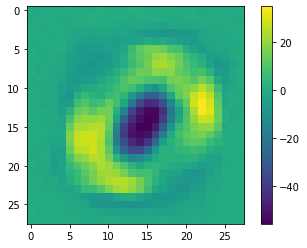

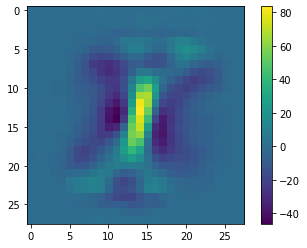

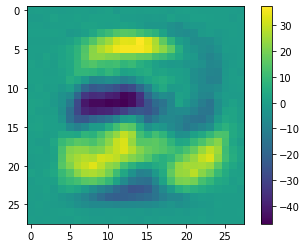

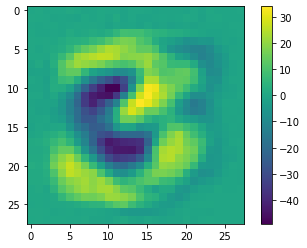

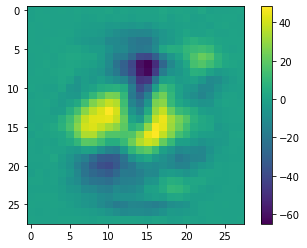

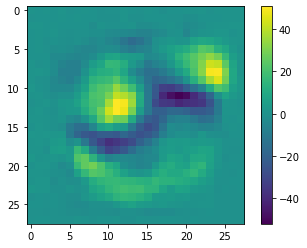

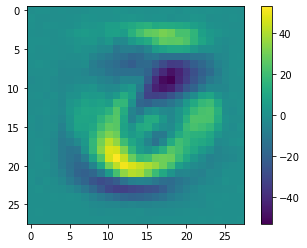

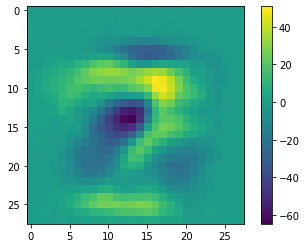

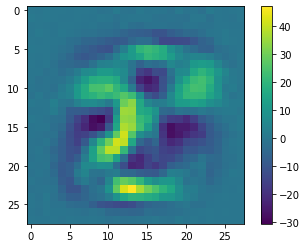

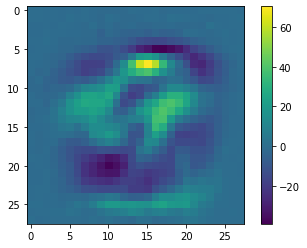

Final testing accuracy: 88.02%


In [27]:
if __name__ == '__main__':
    training_error, training_acc, testing_error, testing_acc, Theta = logistic()
    # plot plots and curves
    visual(Theta)
    plot(training_error, training_acc, testing_error, testing_acc)
    Theta = pd.read_pickle(r'multiclass_parameters.txt')
    testing_set = load_images(all_testing_image_paths)
    test_loss, test_acc = Loss_acc(testing_set, testing_labels, Theta)
    print('Final testing accuracy: %.2f%%' % (test_acc * 100))